Neste notebook comparamos os modelos OMD sexuado, modelo completo sexuado e OMD assexuado.

In [1]:
#Importando bibliotecas
%matplotlib inline
import numpy as np
from numpy import sin, exp, sqrt, pi
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint, quad, dblquad
from scipy.integrate import trapezoid as trapz
from scipy.interpolate import CubicSpline
import warnings

In [2]:
#Definindo funções
def normal(z, zbar, V):
    return 1 / np.sqrt(2*np.pi*V) * np.exp(-(z-zbar)**2/(2*V))

def densidade(z, x, qtdz):
    soma = 0
    for j in range(qtdz):
        soma += x[1+j] * normal(z, x[1+2*qtdz+j], x[1+qtdz+j])
    return x[0] * soma

In [3]:
#Modelo completo sexuado para n morfos
def cria_modelo_completo(b0, s, d0, w, sigmaA, sigmaf, xmax, num):
    z = np.linspace(-xmax, xmax, num)
    dx = 2*xmax/(num-1)
    if dx > sigmaA:
        raise(ValueError(f"dx = {dx}, sigmaA = {sigmaA}, mas dx deve ser *menor* que sigmaA"))
    
    def b(x):
        return b0 - s*x**2
    def c(x):
        return np.exp(-x**2/(2*w**2))
    def d(x, z, n):
        return d0 + trapz(c(z - x) * n, z)
    @np.vectorize
    def A(u, v):
        return 1/(2*np.pi*sigmaA**2)*np.exp(-(u-v)**2/sigmaA**2)
    
    def Nfilho(x, u, v):
        return 1/(np.sqrt(2*np.pi)*sigmaf)*np.exp(-1/2*((x-(u+v)/2)/sigmaf)**2)
    
    def integral_dentro(x, u, fn):
        return ((1/(2 * np.pi * sigmaA**2 * np.sqrt(2*np.pi) * sigmaf)) * 
                2 * np.sqrt(np.pi * (2*sigmaf**2)) * 
                fn(2*x-u) * np.exp(-4*(u-x)**2/sigmaA**2))
    integral_dentro = np.vectorize(integral_dentro, excluded=set([1, 2, "u", "fn"]))
    
    def beta(x, n, Nu, fn):
        return trapz(n / Nu * integral_dentro(x, z, fn), z)
    beta = np.vectorize(beta, excluded=set([1, 2, 3, "n", "Nu", "fn"]))
    
    Auv = []
    for uu in z:
        Auv.append(A(uu, z))
    Auv = np.array(Auv)
    
    #def eq(t, n):
    def eq(n, t):
        fn = CubicSpline(z, n)
        Nu = np.apply_along_axis(trapz, 0, Auv * n, z)
        
        dn = np.zeros(num)
        for i in range(num):
            dn[i] = beta(z[i], n, Nu, fn) * b(z[i]) - d(z[i], z, n)*n[i]
        return dn
    
    return eq

In [4]:
#Modelo OMD sexuado para 1 morfo
def cria_modelo_OMD_1_pico(b0, s, d0, w, sigmaA, sigmaf):
    def dn(n, z, V):
        return n*(sqrt(2)*sqrt(V)*(-z**2*s + b0)*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + V*(-4*sqrt(2)*sqrt(V)*z*s*(-8*V**3 - 6*V**2*sigmaA**2 - V*sigmaA**4)*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)**2*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) - 4*sqrt(2)*sqrt(V)*z*s*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) - 2*sqrt(2)*sqrt(V)*s*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*sqrt(V)*(-z**2*s + b0)*(-16*V**3 - 12*V**2*sigmaA**2 - 2*V*sigmaA**4)*(-8*V**3 - 6*V**2*sigmaA**2 - V*sigmaA**4)*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)**3*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + 2*sqrt(2)*sqrt(V)*(-z**2*s + b0)*(-8*V**3 - 6*V**2*sigmaA**2 - V*sigmaA**4)*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)**2*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) - z**2*n*exp(-z**2/(2*w**2))/w**4 + n*exp(-z**2/(2*w**2))/w**2 - 2*sqrt(2)*z*s*(-4*V*(2*V + sigmaA**2)**2*(4*V*z + z*sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(2*V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 16*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(sqrt(V)*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**6*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**2*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*(-z**2*s + b0)*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(sqrt(V)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*(-z**2*s + b0)*(-4*V*(2*V + sigmaA**2)**2*(4*V + 2*sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 4*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(2*V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 16*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(2*sqrt(V)*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**6*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**2*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*(-z**2*s + b0)*(-4*V*(2*V + sigmaA**2)**2*(4*V*z + z*sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(2*V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 16*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))*(-8*V**3 - 6*V**2*sigmaA**2 - V*sigmaA**4)*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(sqrt(V)*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**6*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**2*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)**2*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*(-z**2*s + b0)*(-4*V*(2*V + sigmaA**2)**2*(4*V*z + z*sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(2*V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 16*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(sqrt(V)*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**6*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**2*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*(-z**2*s + b0)*(-4*V*(2*V + sigmaA**2)**2*(4*V*z + z*sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(2*V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 16*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(4*V**(3/2)*(2*V + sigmaA**2)**4*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**11*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**3*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**2*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)))/2 - d0 - n*exp(-z**2/(2*w**2)))
    def dV(n, z, V):
        return V**2*(-4*sqrt(2)*sqrt(V)*z*s*(-8*V**3 - 6*V**2*sigmaA**2 - V*sigmaA**4)*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)**2*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) - 4*sqrt(2)*sqrt(V)*z*s*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) - 2*sqrt(2)*sqrt(V)*s*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*sqrt(V)*(-z**2*s + b0)*(-16*V**3 - 12*V**2*sigmaA**2 - 2*V*sigmaA**4)*(-8*V**3 - 6*V**2*sigmaA**2 - V*sigmaA**4)*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)**3*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + 2*sqrt(2)*sqrt(V)*(-z**2*s + b0)*(-8*V**3 - 6*V**2*sigmaA**2 - V*sigmaA**4)*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)**2*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) - z**2*n*exp(-z**2/(2*w**2))/w**4 + n*exp(-z**2/(2*w**2))/w**2 - 2*sqrt(2)*z*s*(-4*V*(2*V + sigmaA**2)**2*(4*V*z + z*sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(2*V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 16*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(sqrt(V)*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**6*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**2*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*(-z**2*s + b0)*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(sqrt(V)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*(-z**2*s + b0)*(-4*V*(2*V + sigmaA**2)**2*(4*V + 2*sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 4*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(2*V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 16*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(2*sqrt(V)*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**6*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**2*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*(-z**2*s + b0)*(-4*V*(2*V + sigmaA**2)**2*(4*V*z + z*sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(2*V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 16*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))*(-8*V**3 - 6*V**2*sigmaA**2 - V*sigmaA**4)*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(sqrt(V)*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**6*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**2*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)**2*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*(-z**2*s + b0)*(-4*V*(2*V + sigmaA**2)**2*(4*V*z + z*sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(2*V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 16*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(sqrt(V)*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**6*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**2*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*(-z**2*s + b0)*(-4*V*(2*V + sigmaA**2)**2*(4*V*z + z*sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(2*V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 16*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(4*V**(3/2)*(2*V + sigmaA**2)**4*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**11*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**3*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**2*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)))
    def dz(n, z, V):
        return V*(-2*sqrt(2)*sqrt(V)*z*s*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*sqrt(V)*(-z**2*s + b0)*(-8*V**3 - 6*V**2*sigmaA**2 - V*sigmaA**4)*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)**2*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + sqrt(2)*sqrt(V)*(-z**2*s + b0)*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/((V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)) + z*n*exp(-z**2/(2*w**2))/w**2 + sqrt(2)*(-z**2*s + b0)*(-4*V*(2*V + sigmaA**2)**2*(4*V*z + z*sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(2*V*sigmaA**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 16*V*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)) + 8*sigmaA**2*sigmaf**2*(8*V**3 + 4*V**2*sigmaA**2 + sigmaA**2*(2*V**2 + V*sigmaA**2)))*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigmaA**6*sigmaf**8 + 65536*V**8*sigmaA**4*sigmaf**10 + 113*V**7*sigmaA**16 + 9024*V**7*sigmaA**14*sigmaf**2 + 201152*V**7*sigmaA**12*sigmaf**4 + 1464320*V**7*sigmaA**10*sigmaf**6 + 2207744*V**7*sigmaA**8*sigmaf**8 + 262144*V**7*sigmaA**6*sigmaf**10 + 16*V**6*sigmaA**18 + 2028*V**6*sigmaA**16*sigmaf**2 + 64160*V**6*sigmaA**14*sigmaf**4 + 644096*V**6*sigmaA**12*sigmaf**6 + 1591296*V**6*sigmaA**10*sigmaf**8 + 458752*V**6*sigmaA**8*sigmaf**10 + V**5*sigmaA**20 + 268*V**5*sigmaA**18*sigmaf**2 + 13552*V**5*sigmaA**16*sigmaf**4 + 199680*V**5*sigmaA**14*sigmaf**6 + 781312*V**5*sigmaA**12*sigmaf**8 + 458752*V**5*sigmaA**10*sigmaf**10 + 16*V**4*sigmaA**20*sigmaf**2 + 1720*V**4*sigmaA**18*sigmaf**4 + 41600*V**4*sigmaA**16*sigmaf**6 + 261632*V**4*sigmaA**14*sigmaf**8 + 286720*V**4*sigmaA**12*sigmaf**10 + 100*V**3*sigmaA**20*sigmaf**4 + 5248*V**3*sigmaA**18*sigmaf**6 + 57600*V**3*sigmaA**16*sigmaf**8 + 114688*V**3*sigmaA**14*sigmaf**10 + 304*V**2*sigmaA**20*sigmaf**6 + 7552*V**2*sigmaA**18*sigmaf**8 + 28672*V**2*sigmaA**16*sigmaf**10 + 448*V*sigmaA**20*sigmaf**8 + 4096*V*sigmaA**18*sigmaf**10 + 256*sigmaA**20*sigmaf**10)*exp((-(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**4*(V*z**2*sigmaA**2*(2*V + sigmaA**2) - 2*V*z**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 4*V*(2*V + sigmaA**2)*(2*V*z**2 + 2*z**2*sigmaf**2) + z**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2) + 2*(4*V*z*sigmaf**2*(2*V + sigmaA**2)*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + V*sigmaA**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 8*V*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))) + 4*sigmaA**2*sigmaf**2*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2))))**2*(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)*(8*V**4*sigmaA**2 + 64*V**4*sigmaf**2 + 5*V**3*sigmaA**4 + 72*V**3*sigmaA**2*sigmaf**2 + V**2*sigmaA**6 + 32*V**2*sigmaA**4*sigmaf**2 + 32*V**2*sigmaA**2*sigmaf**4 + 6*V*sigmaA**6*sigmaf**2 + 32*V*sigmaA**4*sigmaf**4 + 8*sigmaA**6*sigmaf**4))/(2*V*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**5*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)))/(2*sqrt(V)*(2*V + sigmaA**2)**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**6*(8*V**3 + 5*V**2*sigmaA**2 + V*sigmaA**4 + 4*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)**2*(8*V**3*z + 5*V**2*z*sigmaA**2 + V*z*sigmaA**4 + 4*V*z*sigmaA**2*sigmaf**2 + 2*z*sigmaA**4*sigmaf**2)*(8*V**3 + 5*V**2*sigmaA**2 + 8*V**2*sigmaf**2 + V*sigmaA**4 + 8*V*sigmaA**2*sigmaf**2 + 2*sigmaA**4*sigmaf**2)*sqrt(16*V**5*sigmaA**2 + 128*V**5*sigmaf**2 + 18*V**4*sigmaA**4 + 224*V**4*sigmaA**2*sigmaf**2 + 128*V**4*sigmaf**4 + 7*V**3*sigmaA**6 + 152*V**3*sigmaA**4*sigmaf**2 + 256*V**3*sigmaA**2*sigmaf**4 + V**2*sigmaA**8 + 48*V**2*sigmaA**6*sigmaf**2 + 192*V**2*sigmaA**4*sigmaf**4 + 6*V*sigmaA**8*sigmaf**2 + 64*V*sigmaA**6*sigmaf**4 + 8*sigmaA**8*sigmaf**4)))
    def eq_omd(t, cond):
        n = cond[0]
        f = cond[1]
        z = cond[3]
        V = cond[2]

        return np.array([dn(n, z, V),              #dn
                         0,                        #df
                         dV(n, z, V) + VM,         #dV
                         dz(n, z, V)])             #dz
    return eq_omd

In [5]:
#Modelo OMD sexuado para n morfos
def cria_modelo_OMD(b0, s, d0, w, sigmaA, sigmaf, qtdz, VM, xmax):
    def phi(x, cond):
        soma = 0
        for i in range(qtdz):
            soma += cond[i+1]*1/(np.sqrt(2*np.pi*cond[i+1+qtdz]))* \
                    np.exp(-(x-cond[i+1+2*qtdz])**2/(2*cond[i+1+qtdz]))
        return cond[0]*soma
    def dphidx(x, cond):
        soma = 0
        for i in range(qtdz):
            soma += - cond[i+1]*(x-cond[i+1+2*qtdz])/(np.sqrt(2*np.pi*cond[i+1+qtdz])*cond[i+1+qtdz])*\
                    np.exp(-(x-cond[i+1+2*qtdz])**2/(2*cond[i+1+qtdz]))
        return cond[0]*soma
    def d2phidx(x, cond):
        soma = 0
        for i in range(qtdz):
            soma += (cond[i+1] * ((x - cond[i+1+2*qtdz])**2 - cond[i+1+qtdz]) /
            (np.sqrt(2*np.pi*cond[i+1+qtdz])*cond[i+1+qtdz]**2) *
             np.exp(- (x-cond[i+1+2*qtdz])**2 / (2*cond[i+1+qtdz])))
        return cond[0]*soma

    def N(u, cond):
        soma = 0
        for i in range(qtdz):
            f = cond[1+i]
            V = cond[1+i+qtdz]
            z = cond[1+i+2*qtdz]
            soma += (f * np.exp((2*V*(u - z)**2/(2*V + sigmaA**2) - u**2 + 2*u*z - z**2) / 
                                sigmaA**2) / np.sqrt(2*V + sigmaA**2) / (2 * np.pi * sigmaA))
        return soma * cond[0] + np.finfo(np.float64).smallest_normal

    def beta(x, cond):
        epsabs = 1.49e-03
        epsrel=1.49e-02
        return (quad(lambda uu: phi(uu, cond) / N(uu, cond) * intdentro(x, uu, cond), -xmax-2*sigmaA, x-2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0] + 
                quad(lambda uu: phi(uu, cond) / N(uu, cond) * intdentro(x, uu, cond), x-2*sigmaA, x + 2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0] + 
                quad(lambda uu: phi(uu, cond) / N(uu, cond) * intdentro(x, uu, cond), x+2*sigmaA, xmax+2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0])
    def dbeta(x, cond):
        epsabs = 1.49e-03
        epsrel=1.49e-02
        return (quad(lambda uu: phi(uu, cond) / N(uu, cond) * dintdentro(x, uu, cond), -xmax-2*sigmaA, x-2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0] + 
                quad(lambda uu: phi(uu, cond) / N(uu, cond) * dintdentro(x, uu, cond), x-2*sigmaA, x + 2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0] + 
                quad(lambda uu: phi(uu, cond) / N(uu, cond) * dintdentro(x, uu, cond), x+2*sigmaA, xmax+2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0])
    def d2beta(x, cond):
        epsabs = 1.49e-03
        epsrel=1.49e-02
        return (quad(lambda uu: phi(uu, cond) / N(uu, cond) * d2intdentro(x, uu, cond), -xmax-2*sigmaA, x-2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0] + 
                quad(lambda uu: phi(uu, cond) / N(uu, cond) * d2intdentro(x, uu, cond), x-2*sigmaA, x + 2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0] + 
                quad(lambda uu: phi(uu, cond) / N(uu, cond) * d2intdentro(x, uu, cond), x+2*sigmaA, xmax+2*sigmaA,
                    epsabs=epsabs, epsrel=epsrel)[0])
    
    def c(x):
        return np.exp(-x**2/(2*w**2))
    def cd1(x):
        return -x*np.exp(-x**2/(2*w**2))/w**2
    def cd2(x):
        return (x**2 - w**2)*np.exp(-x**2/(2*w**2))/w**4

    def b(x):
        return b0 - s*x**2
    def bd1(x):
        return - 2*s*x
    def bd2(x):
        return - 2*s

    def d(x, cond):
        soma = 0
        for i in range(qtdz):
            soma += cond[i+1]*c(cond[i+1+2*qtdz]-x)
        return d0 + cond[0]*soma
    def dd1(x, cond):
        soma = 0
        for i in range(qtdz):
            soma += cond[i+1]*(-cd1(cond[i+1+2*qtdz]-x))
        return cond[0]*soma
    def dd2(x, cond):
        d2soma = 0
        for i in range(qtdz):
            d2soma += cond[i+1]*cd2(cond[i+1+2*qtdz]-x)
        return cond[0]*d2soma

    def intdentro(x, u, cond):
        soma = 0
        for i in range(qtdz):
            f = cond[1+i]
            V = cond[1+i+qtdz]
            z = cond[1+i+2*qtdz]
            soma += ( f * np.sqrt(4*V + 2*sigmaA**2) * np.exp(2*sigmaf**2*(-4*V*u + 4*V*x - sigmaA**2*u +
                    2*sigmaA**2*x - sigmaA**2*z)**2/(V**2*sigmaA**4 + 8*V**2*sigmaA**2*sigmaf**2 +
                    4*V*sigmaA**4*sigmaf**2) - 4*u**2/sigmaA**2 + 8*u*x/sigmaA**2 - 4*x**2/sigmaA**2 -
                    u**2/(2*V) + 2*u*x/V - u*z/V - 2*x**2/V + 2*x*z/V - z**2/(2*V)) /
                    (2*np.pi**(3/2)*sigmaA*np.sqrt(2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 
                    16*V*sigmaA**2*sigmaf**2 + 4*sigmaA**4*sigmaf**2)) )
        return soma * cond[0]
    def dintdentro(x, u, cond):
        from numpy import sqrt, exp, pi
        soma = 0
        for i in range(qtdz):
            f = cond[1+i]
            V = cond[1+i+qtdz]
            z = cond[1+i+2*qtdz]
            soma += f * (sqrt(2)*(2*V + sigmaA**2)**(3/2)*(4*V*u + sigmaA**2*(u - 2*x + z))*
                         (4*V*u - 4*V*x + sigmaA**2*(u - 2*x + z))*
                         exp(-(4*V*(u**2 - 2*u*x + x**2) + sigmaA**2*
                               (u**2 - 4*u*x + 2*u*z + 4*x**2 - 4*x*z + z**2)/2 -
                               2*sigmaf**2*(4*V*u - 4*V*x + sigmaA**2*(u - 2*x + z))**2/
                               (V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))/
                             (V*sigmaA**2))/(pi**(3/2)*sigmaA*(4*V*u + sigmaA**2*u -
                                        2*sigmaA**2*x + sigmaA**2*z)*(2*V**2*sigmaA**2 + 
                                        16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 
                                        4*sigmaA**4*sigmaf**2)**(3/2)))
        return cond[0] * soma
    def d2intdentro(x, u, cond):
        from numpy import sqrt, exp, pi
        soma = 0
        for i in range(qtdz):
            f = cond[1+i]
            V = cond[1+i+qtdz]
            z = cond[1+i+2*qtdz]
            soma += f * ((4*V*u + sigmaA**2*(u - 2*x + z))*((2*V + sigmaA**2)**2*
                        (V*sigmaA**2*(V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2) + 
                         4*sigmaf**2*(-4*V*u + 4*V*x - sigmaA**2*(u - 2*x + z))**2) - 
                        (2*V**2*sigmaA**2 + 16*V**2*sigmaf**2 + V*sigmaA**4 + 16*V*sigmaA**2*sigmaf**2 + 
                        4*sigmaA**4*sigmaf**2)**2)*
                         sqrt(4*V**2*sigmaA**2 + 32*V**2*sigmaf**2 + 2*V*sigmaA**4 + 32*V*sigmaA**2*sigmaf**2 + 
                              8*sigmaA**4*sigmaf**2)*exp((4*V*(-u**2 + 2*u*x - x**2) + 
                                sigmaA**2*(-u**2 + 4*u*x - 2*u*z - 4*x**2 + 4*x*z - z**2)/2 + 
                                2*sigmaf**2*(-4*V*u + 4*V*x - sigmaA**2*(u - 2*x + z))**2/
                                (V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2))/
                                (V*sigmaA**2))/(2*pi**(3/2)*sigmaA*sigmaf**2*(2*V + sigmaA**2)**(5/2)*
                                (V*sigmaA**2 + 8*V*sigmaf**2 + 4*sigmaA**2*sigmaf**2)**3*
                                (4*V*u + sigmaA**2*u - 2*sigmaA**2*x + sigmaA**2*z)))
        return cond[0] * soma

    def r(x, cond):
        return beta(x, cond)*b(x)/phi(x, cond) - d(x, cond)
    def rd1(x, cond):
        return (phi(x, cond)*beta(x, cond)*bd1(x) + b(x)*phi(x, cond)*dbeta(x, cond) - 
                b(x)*beta(x, cond)*dphidx(x, cond))/phi(x, cond)**2 - dd1(x, cond)
    def rd2(x, cond):
        return (phi(x, cond) * (-beta(x, cond)*b(x)*d2phidx(x, cond)  - 2 * dphidx(x, cond) * 
                                (beta(x, cond)*bd1(x) + b(x)*dbeta(x, cond)) ) +
                phi(x, cond)**2 * (beta(x, cond)*bd2(x) + 2*bd1(x)*dbeta(x, cond) + b(x)*d2beta(x, cond)) + 
                2*b(x)*beta(x, cond)*dphidx(x, cond)**2)/phi(x, cond)**3 - dd2(x, cond)
    def Somafrzbarra(cond):
        soma = 0
        for i in range(qtdz):
            soma += cond[i+1]*r(cond[i+1+2*qtdz], cond)
        return soma

    def eq(t, cond):
        ret = np.zeros_like(cond)
        if any(cond[0:5] < 0):
            raise(ValueError(f"Valores negativos: t={t}, cond={cond}"))

        Somafrzb = Somafrzbarra(cond)
        soma = 0
        for i in range(qtdz):
            soma += cond[i+1]*cond[i+1+qtdz]*rd2(cond[i+1+2*qtdz], cond)
        ret[0] = (Somafrzb + soma/2)*cond[0]                                     #dn

        for j in range(1, qtdz+1):
            ret[j] = cond[j]*(r(cond[j + 2*qtdz], cond) - Somafrzb)              #df
            ret[qtdz + j] = cond[qtdz+j]**2 * rd2(cond[2*qtdz + j], cond) + VM   #dV
            ret[2*qtdz+j] = cond[qtdz+j]*rd1(cond[2*qtdz+j], cond)               #dz
        return ret
    return eq

In [8]:
#Modelo OMD assexuado para n morfos
def eq_lion_omd(x, t, b0, s, w, d0, VM, qtdz):
    def c(x):
        return exp(-x**2/(2*w**2))
    def cd1(x):
        return -x*exp(-x**2/(2*w**2))/w**2
    def cd2(x):
        return (x**2 - w**2)*exp(-x**2/(2*w**2))/w**4
    def r(z):
        soma = 0
        for i in range(qtdz):
            soma += x[i+1]*c(x[i+1+2*qtdz]-z)
        return b0 - s*z**2 - d0 - x[0]*soma
    def rbar():
        soma = 0
        for i in range(qtdz):
            soma += x[i+1]*r(x[i+1+2*qtdz])
        return soma
    
    rb = rbar()
    
    def rd1(z):
        soma = 0
        for i in range(qtdz):
            soma += x[i+1]*cd1(x[i+1+2*qtdz]-z)
        return -2*s*z+x[0]*soma
    def rd2(z):
        soma = 0
        for i in range(qtdz):
            soma += x[i+1]*cd2(x[i+1+2*qtdz]-z)
        return -2*s-x[0]*soma
    def df(j):
        return x[j]*(r(x[j + 2*qtdz]) - rb)
    def dn():
        soma1 = 0
        for i in range(qtdz):
            soma1 += x[i+1]*x[i+1+qtdz]*rd2(x[i+1+2*qtdz])
        return (rb + soma1/2)*x[0]
    ret = np.zeros_like(x)
    ret[0] = dn()                                                      #dn
    for j in range(1, qtdz+1):
        ret[j] = df(j)                                                 #df
        ret[qtdz + j] = x[qtdz+j]**2 * rd2(x[2*qtdz + j]) + VM         #dV
        ret[2*qtdz+j] = x[qtdz+j]*rd1(x[2*qtdz+j])                     #dz
    return ret

In [9]:
#Parâmetros
xmax = 3
num2 = 1201
num = 100
temp = 50
b0 = 1
s = 0.1
w = 2
d0 = 0
VM = 0 
qtdz = 2

#Tempo
t = np.arange(0, temp, 5)
x0 = np.array([1., 2/3, 1/3, 0.01, 0.01, 0.5, -0.5])

In [10]:
#Rodando modelo OMD assexuado
%%time

z = np.arange(-1.5, 1.5, 0.0001)
z_omd = np.arange(-1.5, 1.5, 0.01)
z_comp = np.linspace(-xmax, xmax, num2)
lion_omd = odeint(eq_lion_omd, x0, t, (b0, s, w, d0, VM, qtdz))
n_lion_omd = densidade(z, lion_omd[-1], 2)

CPU times: total: 15.6 ms
Wall time: 21 ms


## Comparação entre modelos

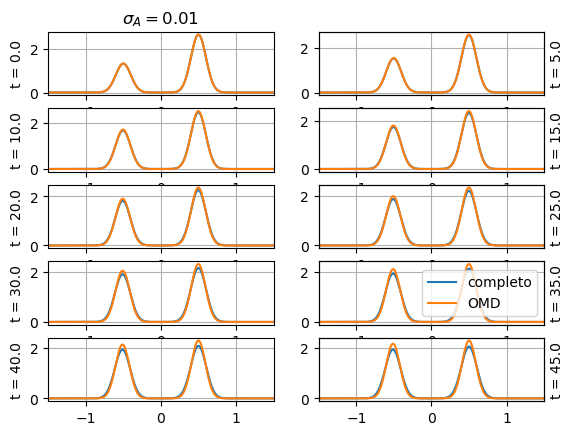

In [30]:
# Comparando OMD e completo sexuado a cada intervalo de tempo
sigmaA = 0.01
npzfile = np.load('Simulações\\dois_picos_sigmaA_'+str(sigmaA)+'.npz', allow_pickle=True)
y_omd = npzfile['y_omd'].item()
for i in range(0, len(y_omd.t)):
    plt.subplot(int(np.ceil(len(y_omd.t)/2)), 2, i+1)
    if i == 0:
        plt.title("$\sigma_A = $"+str(sigmaA))
    
    plt.plot(z_comp, npzfile['y_comp'][i])
    plt.plot(z_omd, densidade(z_omd, y_omd.y[:,i], 2))
    plt.grid()
    plt.xlim(-1.5, 1.5)
    if i+1 == 8:
        plt.legend(["completo", "OMD"])
    if (i+1)%2==0:
        plt.twinx()
        plt.tick_params(right = False, labelright = False)
    plt.ylabel(f"t = {y_omd.t[i]:.1f}")

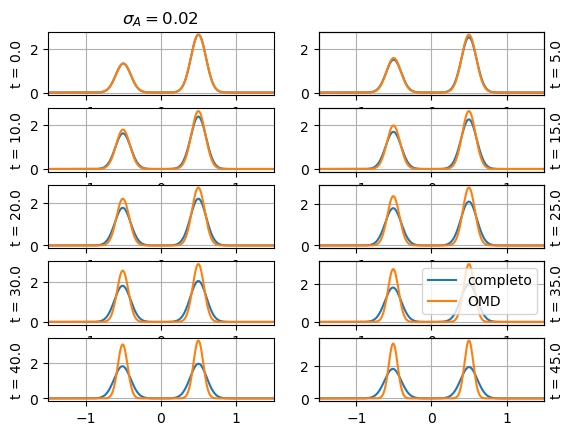

In [31]:
# Comparando OMD e completo sexuado a cada intervalo de tempo
sigmaA = 0.02
npzfile = np.load('Simulações\\dois_picos_sigmaA_'+str(sigmaA)+'.npz', allow_pickle=True)
y_omd = npzfile['y_omd'].item()
for i in range(0, len(y_omd.t)):
    plt.subplot(int(np.ceil(len(y_omd.t)/2)), 2, i+1)
    if i == 0:
        plt.title("$\sigma_A = $"+str(sigmaA))
    
    plt.plot(z_comp, npzfile['y_comp'][i])
    plt.plot(z_omd, densidade(z_omd, y_omd.y[:,i], 2))
    plt.grid()
    plt.xlim(-1.5, 1.5)
    if i+1 == 8:
        plt.legend(["completo", "OMD"])
    if (i+1)%2==0:
        plt.twinx()
        plt.tick_params(right = False, labelright = False)
    plt.ylabel(f"t = {y_omd.t[i]:.1f}")

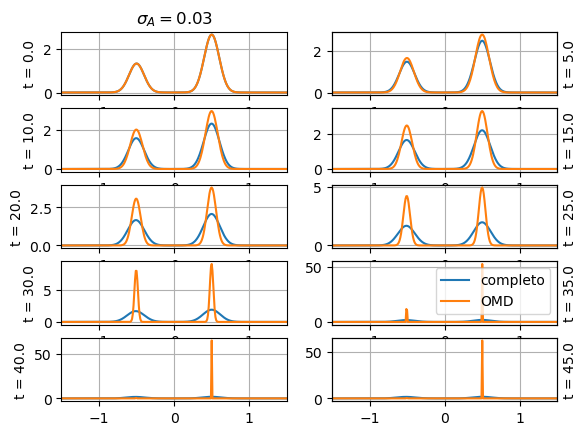

In [32]:
# Comparando OMD e completo sexuado a cada intervalo de tempo
sigmaA = 0.03
npzfile = np.load('Simulações\\dois_picos_sigmaA_'+str(sigmaA)+'.npz', allow_pickle=True)
y_omd = npzfile['y_omd'].item()
for i in range(0, len(y_omd.t)):
    plt.subplot(int(np.ceil(len(y_omd.t)/2)), 2, i+1)
    if i == 0:
        plt.title("$\sigma_A = $"+str(sigmaA))
    
    plt.plot(z_comp, npzfile['y_comp'][i])
    plt.plot(z_omd, densidade(z_omd, y_omd.y[:,i], 2))
    plt.grid()
    plt.xlim(-1.5, 1.5)
    if i+1 == 8:
        plt.legend(["completo", "OMD"])
    if (i+1)%2==0:
        plt.twinx()
        plt.tick_params(right = False, labelright = False)
    plt.ylabel(f"t = {y_omd.t[i]:.1f}")

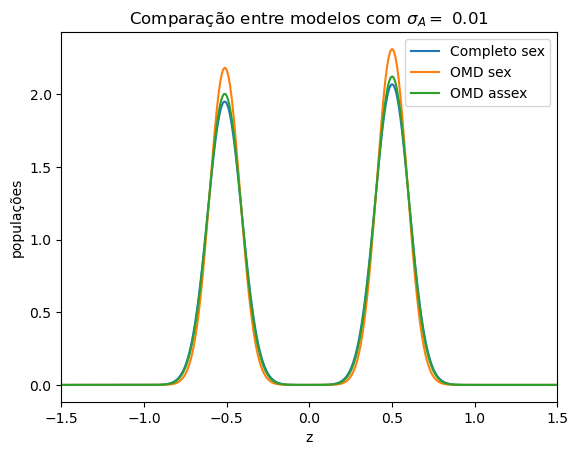

In [58]:
# Comparando OMD e completo sexuado com OMD assexuado no tempo final
sigmaA=0.01
npzfile = np.load('Simulações\\dois_picos_sigmaA_'+str(sigmaA)+'.npz', allow_pickle=True)
y_omd = npzfile['y_omd'].item()
plt.plot(z_comp, npzfile['y_comp'][-1], label=f"Completo sex")
plt.plot(z_omd, densidade(z_omd, y_omd.y[:,-1], qtdz), label=f"OMD sex")


plt.plot(z, n_lion_omd, label="OMD assex")
plt.xlabel('z') 
plt.ylabel('populações')
plt.title("Comparação entre modelos com $\sigma_A =$ "+str(sigmaA))
plt.xlim(-1.5,1.5)
plt.legend()

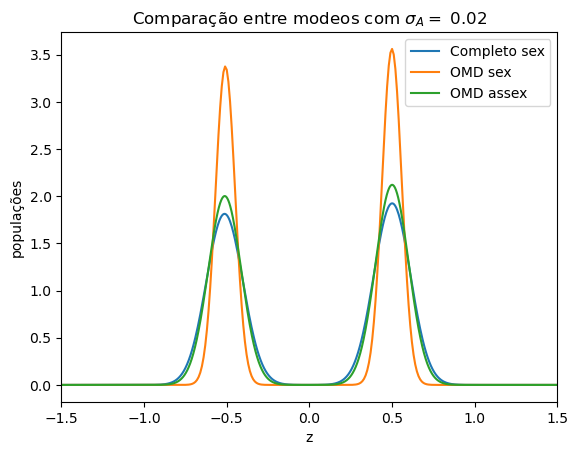

In [59]:
# Comparando OMD e completo sexuado com OMD assexuado no tempo final
sigmaA = 0.02
npzfile = np.load('Simulações\\dois_picos_sigmaA_'+str(sigmaA)+'.npz', allow_pickle=True)
y_omd = npzfile['y_omd'].item()
plt.plot(z_comp, npzfile['y_comp'][-1], label=f"Completo sex")
plt.plot(z_omd, densidade(z_omd, y_omd.y[:,-1], qtdz), label=f"OMD sex")

plt.plot(z, n_lion_omd, label="OMD assex")
plt.xlabel('z') 
plt.ylabel('populações')
plt.title("Comparação entre modeos com $\sigma_A =$ "+str(sigmaA))
plt.xlim(-1.5,1.5)
plt.legend()

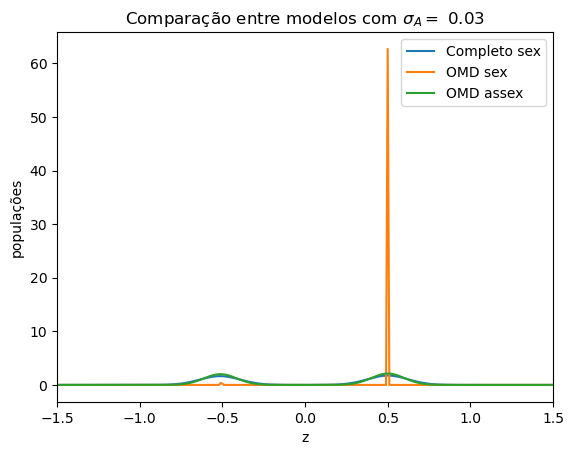

In [60]:
# Comparando OMD e completo sexuado com OMD assexuado no tempo final
sigmaA=0.03
npzfile = np.load('Simulações\\dois_picos_sigmaA_'+str(sigmaA)+'.npz', allow_pickle=True)
y_omd = npzfile['y_omd'].item()
plt.plot(z_comp, npzfile['y_comp'][-1], label=f"Completo sex")
plt.plot(z_omd, densidade(z_omd, y_omd.y[:,-1], qtdz), label=f"OMD sex")

plt.plot(z, n_lion_omd, label="OMD assex")
plt.xlabel('z') 
plt.ylabel('populações')
plt.title("Comparação entre modelos com $\sigma_A =$ "+str(sigmaA))
plt.xlim(-1.5,1.5)
plt.legend()

### Comparando populações totais

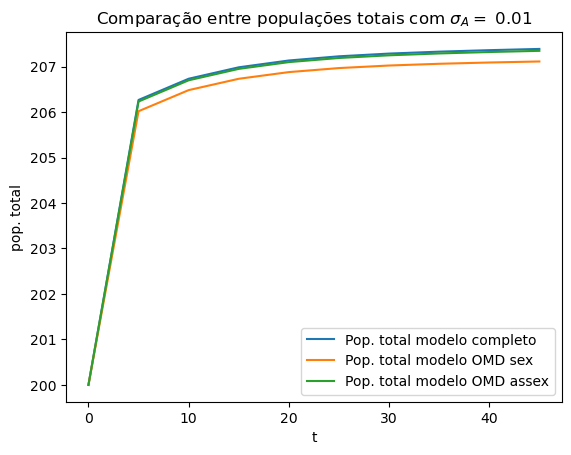

In [68]:
#Plot das populações totais dos modelos completo, OMD sexuado e OMD assexuado

sigmaA=0.01
temp = 50
t = np.arange(0, temp, 5) 
npzfile = np.load('Simulações\\dois_picos_sigmaA_'+str(sigmaA)+'.npz', allow_pickle=True)
y_omd = npzfile['y_omd'].item()

pop_comp = []
pop_OMD_sex = []
pop_OMD_assex = []
for i in range(len(t)):
    pop_comp.append(npzfile['y_comp'][i].sum())
    pop_OMD_sex.append(2*densidade(z_omd, y_omd.y[:,i], qtdz).sum()) 
    pop_OMD_assex.append(densidade(z, lion_omd[i], 2).sum()/50)
plt.plot(t, pop_comp, label=f"Pop. total modelo completo")
plt.plot(t, pop_OMD_sex, label=f"Pop. total modelo OMD sex")
plt.plot(t, pop_OMD_assex, label=f"Pop. total modelo OMD assex")
plt.title("Comparação entre populações totais com $\sigma_A =$ "+str(sigmaA))
plt.xlabel('t') 
plt.ylabel('pop. total')
plt.legend()

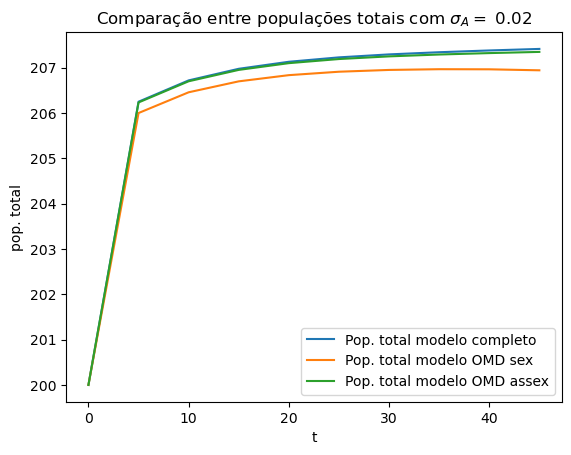

In [69]:
#Plot das populações totais dos modelos completo, OMD sexuado e OMD assexuado
sigmaA=0.02
npzfile = np.load('Simulações\\dois_picos_sigmaA_'+str(sigmaA)+'.npz', allow_pickle=True)
y_omd = npzfile['y_omd'].item()

pop_comp = []
pop_OMD_sex = []
pop_OMD_assex = []
for i in range(len(t)):
    pop_comp.append(npzfile['y_comp'][i].sum())
    pop_OMD_sex.append(2*densidade(z_omd, y_omd.y[:,i], qtdz).sum()) 
    pop_OMD_assex.append(densidade(z, lion_omd[i], 2).sum()/50)
plt.plot(t, pop_comp, label=f"Pop. total modelo completo")
plt.plot(t, pop_OMD_sex, label=f"Pop. total modelo OMD sex")
plt.plot(t, pop_OMD_assex, label=f"Pop. total modelo OMD assex")
plt.title("Comparação entre populações totais com $\sigma_A =$ "+str(sigmaA))
plt.xlabel('t') 
plt.ylabel('pop. total')
plt.legend()

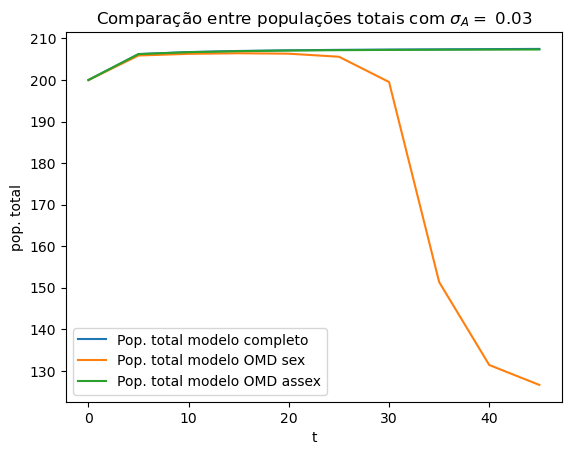

In [70]:
#Plot das populações totais dos modelos completo, OMD sexuado e OMD assexuado
sigmaA=0.03
npzfile = np.load('Simulações\\dois_picos_sigmaA_'+str(sigmaA)+'.npz', allow_pickle=True)
y_omd = npzfile['y_omd'].item()

pop_comp = []
pop_OMD_sex = []
pop_OMD_assex = []
for i in range(len(t)):
    pop_comp.append(npzfile['y_comp'][i].sum())
    pop_OMD_sex.append(2*densidade(z_omd, y_omd.y[:,i], qtdz).sum())
    pop_OMD_assex.append(densidade(z, lion_omd[i], 2).sum()/50)
plt.plot(t, pop_comp, label=f"Pop. total modelo completo")
plt.plot(t, pop_OMD_sex, label=f"Pop. total modelo OMD sex")
plt.plot(t, pop_OMD_assex, label=f"Pop. total modelo OMD assex")
plt.title("Comparação entre populações totais com $\sigma_A =$ "+str(sigmaA))
plt.xlabel('t') 
plt.ylabel('pop. total')
plt.legend()

## Comparação com um morfo

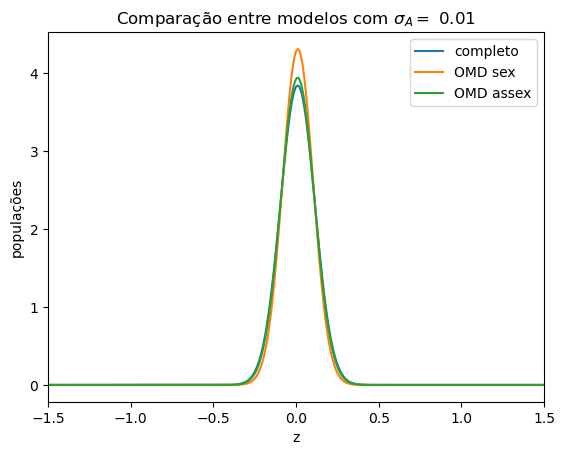

In [71]:
#Comparação no tempo final entre modelos completo, OMD sexuado e OMD assexuado para um morfo
sigmaA = 0.01

npzfile = np.load('Simulações\\um_pico_sigmaA_'+str(sigmaA)+'.npz', allow_pickle=True)
plt.plot(z_comp, npzfile['y_comp'][-1], label="completo")

eq_1pico = cria_modelo_OMD_1_pico(b0, s, d0, w, sigmaA, sigmaf)
y_1pico = solve_ivp(eq_1pico, (0, temp), x0_1pico, method="Radau", t_eval=t)
plt.plot(z_omd, densidade(z_omd, y_1pico.y[:,-1], 1), label="OMD sex")

lion_omd_1pico = odeint(eq_lion_omd, x0_1pico, t, (b0, s, w, d0, VM, 1))
n_lion_omd_1pico = densidade(z, lion_omd_1pico[-1], 1)

plt.plot(z, n_lion_omd_1pico, label="OMD assex")

plt.title(r"Comparação entre modelos com $\sigma_A =$ "+str(sigmaA))
plt.xlim(-1.5,1.5)
plt.xlabel("z")
plt.ylabel("populações")
plt.legend()

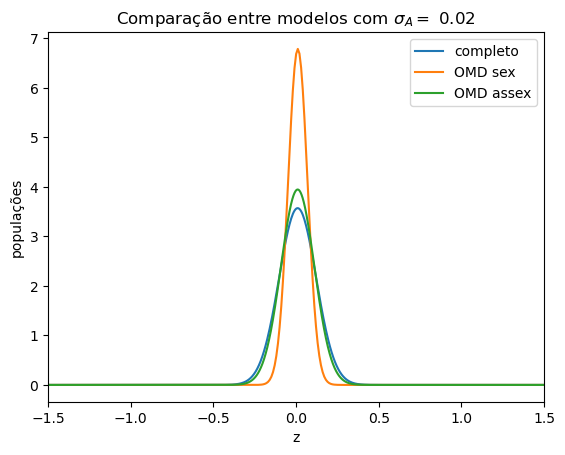

In [73]:
#Comparação no tempo final entre modelos completo, OMD sexuado e OMD assexuado para um morfo
sigmaA = 0.02
npzfile = np.load('Simulações\\um_pico_sigmaA_'+str(sigmaA)+'.npz', allow_pickle=True)

plt.plot(z_comp, npzfile['y_comp'][-1], label="completo")

eq_1pico = cria_modelo_OMD_1_pico(b0, s, d0, w, sigmaA, sigmaf)
y_1pico = solve_ivp(eq_1pico, (0, temp), x0_1pico, method="Radau", t_eval=t)
plt.plot(z_omd, densidade(z_omd, y_1pico.y[:,-1], 1), label="OMD sex")

lion_omd_1pico = odeint(eq_lion_omd, np.array([1., 2/3, 0.01, 0.01]), t, (b0, s, w, d0, VM, 1))
n_lion_omd_1pico = densidade(z, lion_omd_1pico[-1], 1)

plt.plot(z, n_lion_omd_1pico, label="OMD assex")

plt.title(r"Comparação entre modelos com $\sigma_A =$ "+str(sigmaA))
plt.xlim(-1.5,1.5)
plt.xlabel("z")
plt.ylabel("populações")
plt.legend()

C:\Users\danie\AppData\Local\Temp\ipykernel_12792\2905747049.py:4: RuntimeWarning: invalid value encountered in sqrt
  return n*(sqrt(2)*sqrt(V)*(-z**2*s + b0)*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigma

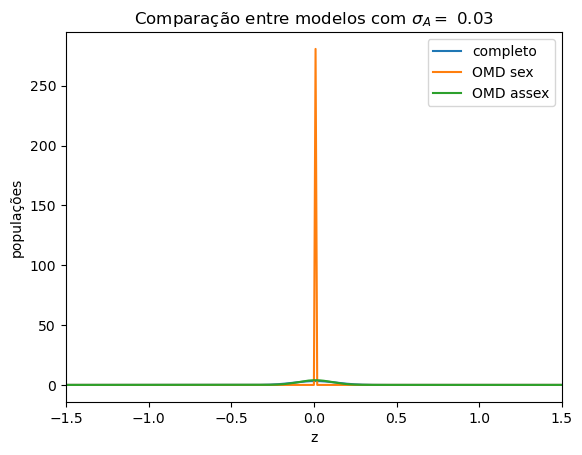

In [75]:
#Comparação no tempo final entre modelos completo, OMD sexuado e OMD assexuado para um morfo
sigmaA = 0.03
npzfile = np.load('Simulações\\um_pico_sigmaA_'+str(sigmaA)+'.npz', allow_pickle=True)

plt.plot(z_comp, npzfile['y_comp'][-1], label="completo")

eq_1pico = cria_modelo_OMD_1_pico(b0, s, d0, w, sigmaA, sigmaf)
y_1pico = solve_ivp(eq_1pico, (0, temp), x0_1pico, method="Radau", t_eval=t)
plt.plot(z_omd, densidade(z_omd, y_1pico.y[:,-1], 1), label="OMD sex")

lion_omd_1pico = odeint(eq_lion_omd, np.array([1., 2/3, 0.01, 0.01]), t, (b0, s, w, d0, VM, 1))
n_lion_omd_1pico = densidade(z, lion_omd_1pico[-1], 1)

plt.plot(z, n_lion_omd_1pico, label="OMD assex")

plt.title(r"Comparação entre modelos com $\sigma_A =$ "+str(sigmaA))
plt.xlim(-1.5,1.5)
plt.xlabel("z")
plt.ylabel("populações")
plt.legend()

## Comparando modelo numérico com análitico para um morfo

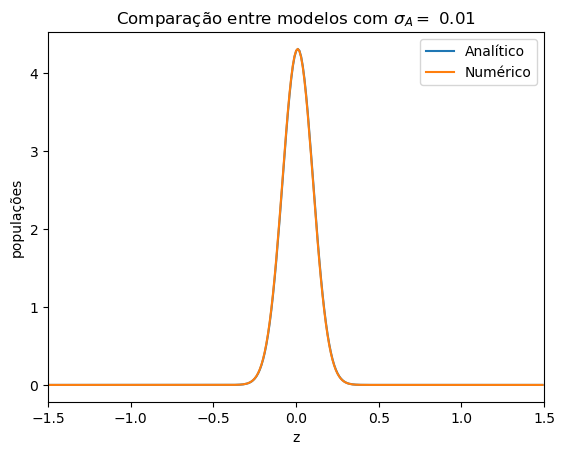

In [76]:
#Comparação entre modelo OMD sexuado obtido numericamente e analiticamente no caso de um morfo
sigmaA = 0.01
sigmaf = 0.001
x0_1pico = np.array([1., 1., 0.01, 0.01])

eq_1pico = cria_modelo_OMD_1_pico(b0, s, d0, w, sigmaA, sigmaf)
y_1pico = solve_ivp(eq_1pico, (0, temp), x0_1pico, method="Radau", t_eval=t)
plt.plot(z_omd, densidade(z_omd, y_1pico.y[:,-1], 1), label="Analítico")

eq_omd = cria_modelo_OMD(b0, s, d0, w, sigmaA, sigmaf, 1, VM, xmax)
y_omd = solve_ivp(eq_omd, (0, temp), x0_1pico, method="Radau", t_eval=t)
plt.plot(z_omd, densidade(z_omd, y_omd.y[:,-1], 1), label="Numérico")

plt.title(r"Comparação entre modelos com $\sigma_A =$ "+str(sigmaA))
plt.xlim(-1.5,1.5)
plt.xlabel("z")
plt.ylabel("populações")
plt.legend()

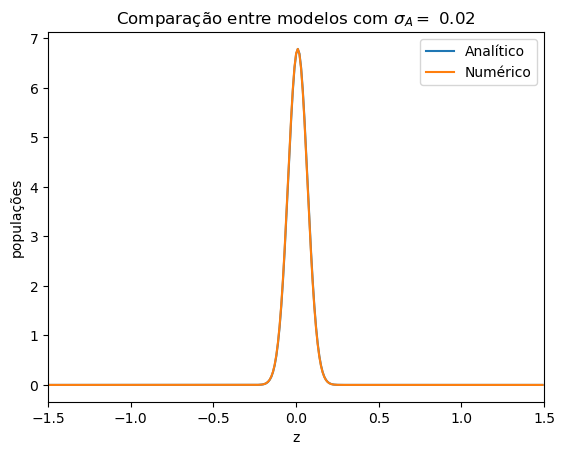

In [77]:
#Comparação entre modelo OMD sexuado obtido numericamente e analiticamente no caso de um morfo
sigmaA = 0.02
sigmaf = 0.001
x0_1pico = np.array([1., 1., 0.01, 0.01])

eq_1pico = cria_modelo_OMD_1_pico(b0, s, d0, w, sigmaA, sigmaf)
y_1pico = solve_ivp(eq_1pico, (0, temp), x0_1pico, method="Radau", t_eval=t)
plt.plot(z_omd, densidade(z_omd, y_1pico.y[:,-1], 1), label="Analítico")

eq_omd = cria_modelo_OMD(b0, s, d0, w, sigmaA, sigmaf, 1, VM, xmax)
y_omd = solve_ivp(eq_omd, (0, temp), x0_1pico, method="Radau", t_eval=t)
plt.plot(z_omd, densidade(z_omd, y_omd.y[:,-1], 1), label="Numérico")

plt.title(r"Comparação entre modelos com $\sigma_A =$ "+str(sigmaA))
plt.xlim(-1.5,1.5)
plt.xlabel("z")
plt.ylabel("populações")
plt.legend()

C:\Users\danie\AppData\Local\Temp\ipykernel_12792\2905747049.py:4: RuntimeWarning: invalid value encountered in sqrt
  return n*(sqrt(2)*sqrt(V)*(-z**2*s + b0)*(8*V**3*z + 4*V**2*z*sigmaA**2 + sigmaA**2*(2*V**2*z + V*z*sigmaA**2 + z*(-V**2 + 4*V*sigmaf**2 + 2*sigmaA**2*sigmaf**2)))*sqrt(512*V**12*sigmaA**6 + 12288*V**12*sigmaA**4*sigmaf**2 + 98304*V**12*sigmaA**2*sigmaf**4 + 262144*V**12*sigmaf**6 + 1408*V**11*sigmaA**8 + 39936*V**11*sigmaA**6*sigmaf**2 + 368640*V**11*sigmaA**4*sigmaf**4 + 1114112*V**11*sigmaA**2*sigmaf**6 + 1672*V**10*sigmaA**10 + 57536*V**10*sigmaA**8*sigmaf**2 + 628224*V**10*sigmaA**6*sigmaf**4 + 2232320*V**10*sigmaA**4*sigmaf**6 + 262144*V**10*sigmaA**2*sigmaf**8 + 1116*V**9*sigmaA**12 + 48192*V**9*sigmaA**10*sigmaf**2 + 641280*V**9*sigmaA**8*sigmaf**4 + 2785280*V**9*sigmaA**6*sigmaf**6 + 1081344*V**9*sigmaA**4*sigmaf**8 + 454*V**8*sigmaA**14 + 25760*V**8*sigmaA**12*sigmaf**2 + 433280*V**8*sigmaA**10*sigmaf**4 + 2390016*V**8*sigmaA**8*sigmaf**6 + 2007040*V**8*sigma

ValueError: Valores negativos: t=31.0, cond=[ 9.92869700e-01  1.00000000e+00 -1.44425756e-04  9.68979932e-03]

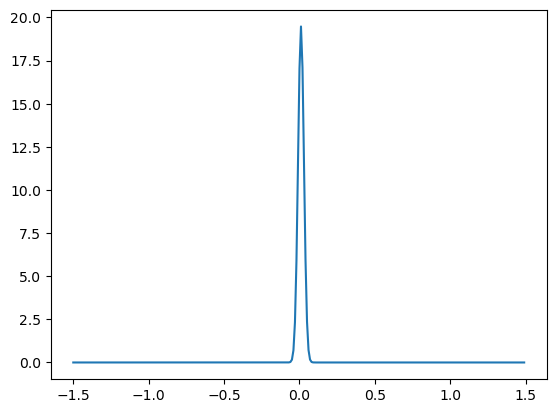

In [56]:
#Comparação entre modelo OMD sexuado obtido numericamente e analiticamente no caso de um morfo
sigmaA = 0.03
sigmaf = 0.001
x0_1pico = np.array([1., 1., 0.01, 0.01])

temp = 31
t = np.arange(0, temp, 1)
eq_1pico = cria_modelo_OMD_1_pico(b0, s, d0, w, sigmaA, sigmaf)
y_1pico = solve_ivp(eq_1pico, (0, temp), x0_1pico, method="Radau", t_eval=t)
plt.plot(z_omd, densidade(z_omd, y_1pico.y[:,-1], 1), label="Analítico")

eq_omd = cria_modelo_OMD(b0, s, d0, w, sigmaA, sigmaf, 1, VM, xmax)
y_omd = solve_ivp(eq_omd, (0, temp), x0_1pico, method="Radau", t_eval=t)
plt.plot(z_omd, densidade(z_omd, y_omd.y[:,-1], 1), label="Numérico")

plt.title(r"Comparação modelos com $\sigma_A =$ "+str(sigmaA))
plt.xlim(-1.5,1.5)
plt.xlabel("z")
plt.ylabel("populações")
plt.legend()